In [1]:
!pip install xgboost
!pip install catboost

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import warnings

warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [4]:
print("Full train dataset shape is {}".format(df_train.shape))
print("Full test dataset shape is {}".format(df_test.shape))

Full train dataset shape is (8693, 14)
Full test dataset shape is (4277, 13)


In [5]:
df_train.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
4344,4625_07,Europa,True,B/183/S,55 Cancri e,29.0,False,0.0,0.0,0.0,0.0,0.0,Sadiram Ineedeve,True
6250,6614_01,Mars,True,F/1268/S,TRAPPIST-1e,29.0,False,0.0,0.0,0.0,0.0,0.0,Naffsh Katte,True
8597,9178_01,Earth,False,F/1877/P,TRAPPIST-1e,53.0,False,49.0,584.0,0.0,0.0,70.0,Ernard Barnoldeney,False
5360,5725_01,Earth,False,F/1094/S,TRAPPIST-1e,24.0,False,156.0,0.0,364.0,489.0,383.0,Clindy Joycerton,True
815,0867_01,Earth,False,F/163/S,TRAPPIST-1e,NaN,False,2.0,850.0,18.0,2.0,0.0,Ernice Stephendsey,False


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
df_train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [8]:
# checking for the duplicate values
df_train.duplicated().sum()

0

In [9]:
# separating categorical columns and numerical columns
categorical_cols = df_train.select_dtypes(include = ['object']).columns
numerical_cols = df_train.select_dtypes(include = ['float64', 'int64']).columns

print(categorical_cols, numerical_cols)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP',
       'Name'],
      dtype='object') Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')


# Exploratory data analysis (EDA)

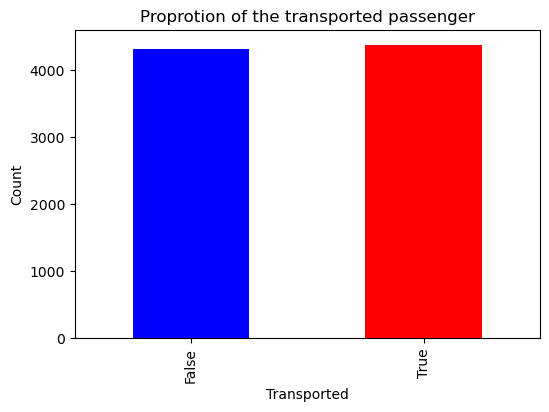

In [32]:
plt.figure(figsize=(6,4))

y.value_counts().sort_index().plot(kind='bar' , color=['blue', 'red'])
plt.xlabel('Transported')
plt.ylabel('Count')
plt.title('Proprotion of the transported passenger')

plt.show()

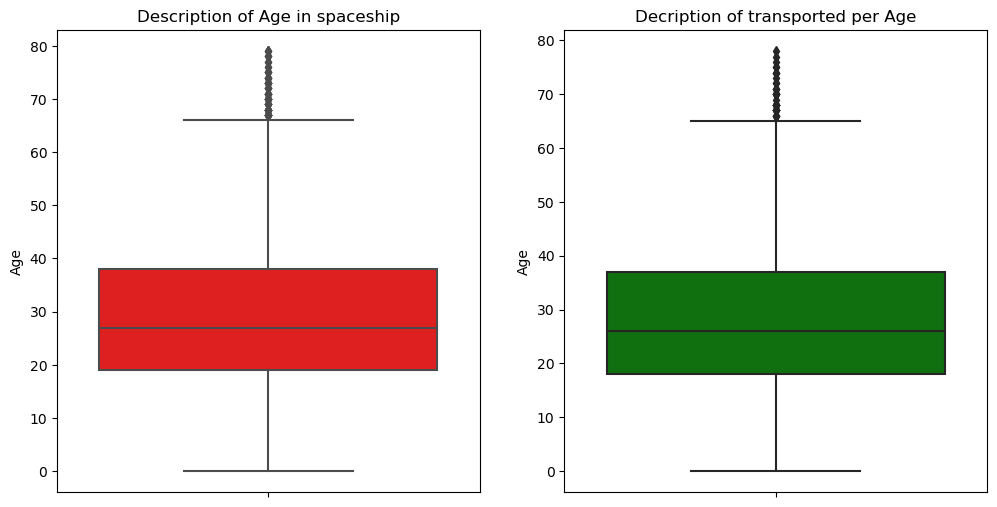

In [53]:
plt.figure(figsize=(12,6))

transported_passenger = df_train[df_train['Transported'] == True]

plt.subplot(1, 2, 1)
sns.boxplot(data=df_train, y='Age', color='red')
plt.title('Description of Age in spaceship')

plt.subplot(1, 2, 2)
sns.boxplot(y=transported_passenger['Age'], color='green')
plt.title('Decription of transported per Age')

plt.show()

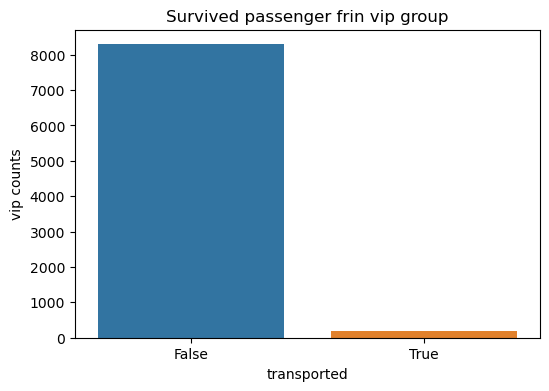

In [54]:
# Understanding how many VIP passenger have Survived
plt.figure(figsize=(6,4))

transported_vip = df_train.groupby('VIP')['Transported'].count()

sns.barplot(y=transported_vip.values, x=transported_vip.index)

plt.title( 'Survived passenger frin vip group' )  
plt.xlabel( 'transported' )
plt.ylabel( 'vip counts' )

plt.show()

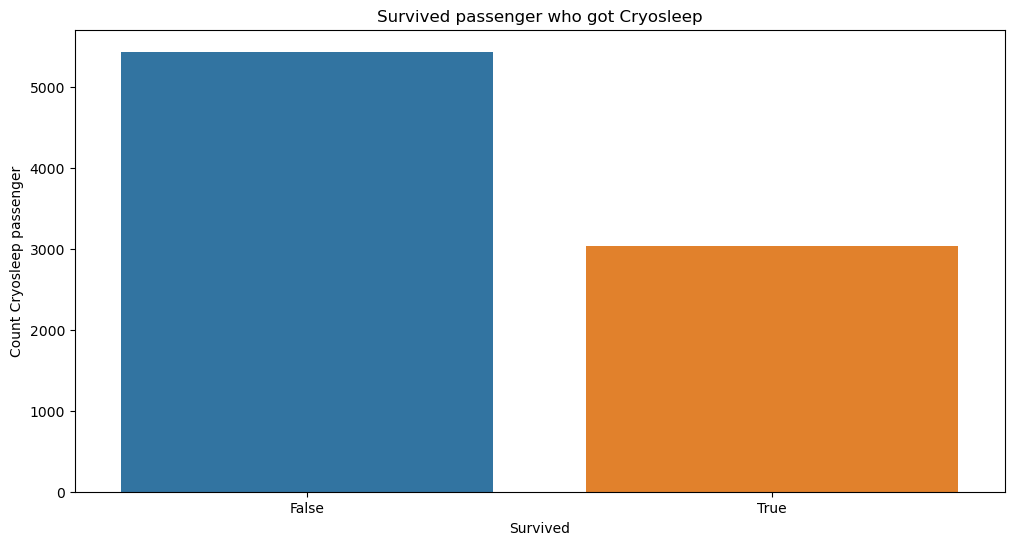

In [42]:
plt.figure(figsize=(12,6))

transported_cryosleep = df_train.groupby('CryoSleep')['Transported'].count()

sns.barplot(y=transported_cryosleep.values, x=transported_cryosleep.index)

plt.title('Survived passenger who got Cryosleep')
plt.xlabel('Survived')
plt.ylabel('Count Cryosleep passenger')

plt.show()

In [43]:
df_train['HomePlanet'].value_counts()

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

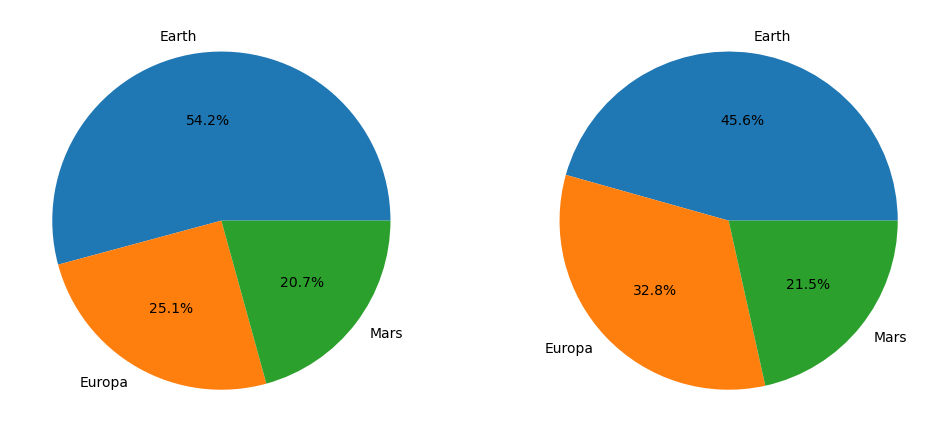

In [55]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.pie(data= df_train,
        labels=df_train['HomePlanet'].value_counts().index,
        x=df_train['HomePlanet'].value_counts(),
       autopct='%1.1f%%'
       )

plt.subplot(1,2,2)
plt.pie(data= transported_passenger,
        labels=transported_passenger['HomePlanet'].value_counts().index,
        x=transported_passenger['HomePlanet'].value_counts(),
       autopct='%1.1f%%'
       )

plt.show()

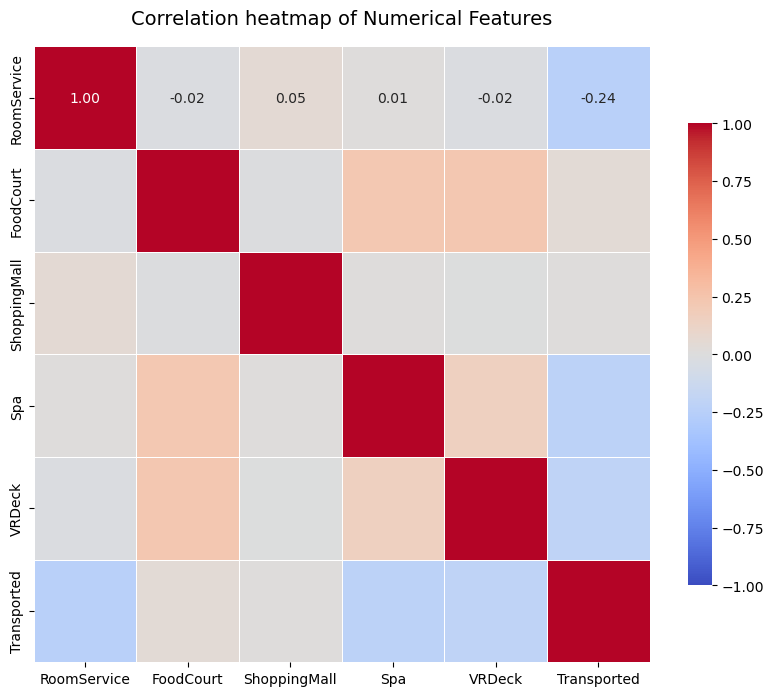

In [60]:
plt.figure(figsize=(10,8))

sns.heatmap(df_train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Transported']].corr(),
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            linewidths=0.5,
            square=True,
            cbar_kws={"shrink": 0.75}
           )

plt.title("Correlation heatmap of Numerical Features",fontsize=14, pad=16)

plt.show()
    

In [61]:
# there are three columns who have more realtion with the tramsported panssenger

# Preprocessing and organizing the data

In [62]:
# since the other catogorical columns would need a deep anaylysis 
# about the how i showl work with them, since The discription  of the dataset we know tha the 
# homePlanet column have importance for model

In [63]:
df_train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [65]:
df_train[(df_train['CryoSleep'].isnull()) & (df_train['Transported'] == 1)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
92,0099_02,Earth,NaN,G/12/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,0.0,0.0,Thewis Connelson,True
111,0115_01,Mars,NaN,F/24/P,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,NaN,Rohs Pead,True
152,0173_01,Earth,NaN,E/11/S,TRAPPIST-1e,58.0,False,0.0,985.0,0.0,5.0,0.0,Hilip Grifford,True
175,0198_01,Earth,NaN,G/30/P,PSO J318.5-22,52.0,False,0.0,0.0,0.0,0.0,0.0,Jeroy Cookson,True
266,0290_03,Europa,NaN,B/7/S,TRAPPIST-1e,43.0,False,0.0,0.0,0.0,0.0,0.0,Dhenar Excialing,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8362,8944_02,Earth,NaN,G/1442/S,PSO J318.5-22,17.0,False,0.0,0.0,0.0,0.0,0.0,Evan Hobbinson,True
8620,9197_01,Europa,NaN,C/308/P,55 Cancri e,44.0,False,0.0,0.0,0.0,0.0,0.0,Bellus Platch,True
8664,9246_01,Earth,NaN,G/1490/S,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,0.0,0.0,NaN,True
8675,9259_01,Earth,NaN,F/1893/P,TRAPPIST-1e,44.0,False,1030.0,1015.0,0.0,11.0,NaN,Annah Gilleyons,True


In [66]:
df_train[(df_train['CryoSleep'].isnull())]['Transported'].describe()

count       217
unique        2
top       False
freq        111
Name: Transported, dtype: object

In [67]:
df_train[(df_train['VIP'].isnull())]['Transported'].describe()

count      203
unique       2
top       True
freq       104
Name: Transported, dtype: object

In [68]:
df_train[(df_train['CryoSleep'].isnull()) & (df_train['VIP'].isnull())]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
1017,1085_01,Earth,NaN,G/165/P,TRAPPIST-1e,54.0,NaN,0.0,0.0,0.0,0.0,0.0,Troyce Wagnerray,False
1383,1453_01,Earth,NaN,G/229/P,55 Cancri e,16.0,NaN,0.0,2838.0,32.0,5.0,3404.0,Kimena Thorney,False
2560,2747_01,Mars,NaN,F/570/P,TRAPPIST-1e,49.0,NaN,0.0,0.0,0.0,0.0,0.0,Stisps Chrie,True
2639,2822_02,Earth,NaN,G/450/S,TRAPPIST-1e,5.0,NaN,0.0,0.0,0.0,0.0,NaN,Salley Harverez,False
5409,5777_01,Earth,NaN,F/1199/P,PSO J318.5-22,46.0,NaN,559.0,25.0,NaN,22.0,765.0,Katen River,False
5697,6035_02,Earth,NaN,G/976/P,TRAPPIST-1e,3.0,NaN,0.0,0.0,0.0,0.0,0.0,Ginald Morsentley,False
6373,6741_02,Earth,NaN,F/1286/S,PSO J318.5-22,18.0,NaN,103.0,0.0,181.0,1611.0,22.0,Jeandy Reyersendry,False


In [69]:
df_train.drop(columns=['Cabin', 'Destination', 'Name'], inplace=True)
df_test.drop(columns=['Cabin', 'Destination', 'Name'], inplace=True)

df_train['VIP'].fillna(-1, inplace=True)
df_train['CryoSleep'].fillna(-1, inplace=True)

df_test['VIP'].fillna(-1, inplace=True)
df_test['CryoSleep'].fillna(-1, inplace=True)

X = df_train.drop(columns='Transported')
y = df_train['Transported']

In [70]:
numerical_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_columns = ['HomePlanet'] # HomePLanet is the only column I'm going to use

numerical_transform = SimpleImputer(strategy='mean')

categorical_transform = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transform, numerical_columns),
        ('cat', categorical_transform, categorical_columns)
])

In [75]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=2 )

# RandomeForest Accuracy

In [76]:
rf_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(
            random_state=42,
            n_estimators=100)
        )
    ])

rf_pipeline.fit(x_train, y_train)

rf_predicts = rf_pipeline.predict(x_valid)

print(accuracy_score(y_valid, rf_predicts))

0.7918343875790684


# XGBoost accuracy

In [83]:
xgb_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', XGBClassifier(
            random_state=2,
            learning_rate=0.02,
            n_estimators=350)
        )
    ])

xgb_pipeline.fit(x_train, y_train)

xgb_pipeline = xgb_pipeline.predict(x_valid)

print(accuracy_score(y_valid, xgb_pipeline))

0.7938470385278896


In [106]:
xgb_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', XGBClassifier(
            random_state=2,
            learning_rate=0.008,
            n_estimators=330)
        )
    ])

xgb_pipeline.fit(x_train, y_train)
xgb_predict = xgb_pipeline.predict(x_valid)

print("Accuracy XGBoost:", accuracy_score(y_valid, xgb_predict))
print("Report XGBoost:\n", classification_report(y_valid, xgb_predict))

Accuracy XGBoost: 0.7944220816561242
Report XGBoost:
               precision    recall  f1-score   support

       False       0.82      0.74      0.78      1706
        True       0.77      0.85      0.81      1772

    accuracy                           0.79      3478
   macro avg       0.80      0.79      0.79      3478
weighted avg       0.80      0.79      0.79      3478



In [90]:
knn_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=6)
        )
    ])

knn_pipeline.fit(x_train, y_train)
y_pred_knn = knn_pipeline.predict(x_valid)

print("Accuracy KNN:", accuracy_score(y_valid, y_pred_knn))
print("Report KNN:\n", classification_report(y_valid, y_pred_knn))

Accuracy KNN: 0.7377803335250144
Report KNN:
               precision    recall  f1-score   support

       False       0.68      0.88      0.77      1706
        True       0.84      0.60      0.70      1772

    accuracy                           0.74      3478
   macro avg       0.76      0.74      0.73      3478
weighted avg       0.76      0.74      0.73      3478



# Cheking CatBoost accuracy

In [89]:
cat_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', CatBoostClassifier(
            iterations=100,
            learning_rate=0.02,
            depth=8,
            verbose=0,
            random_state=2)
        )
    ])

cat_pipeline.fit(x_train, y_train)
cat_predict = cat_pipeline.predict(x_valid)

print("Accuracy CatBoost:", accuracy_score(y_valid, cat_predict))
print("Report CatBoost:\n", classification_report(y_valid, cat_predict))

Accuracy CatBoost: 0.7912593444508338
Report CatBoost:
               precision    recall  f1-score   support

       False       0.81      0.76      0.78      1706
        True       0.78      0.82      0.80      1772

    accuracy                           0.79      3478
   macro avg       0.79      0.79      0.79      3478
weighted avg       0.79      0.79      0.79      3478



In [91]:
svm_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', SVC
         (kernel='rbf',
          C=1.0,
          random_state=42)
        )
    ])

svm_pipeline.fit(x_train, y_train)
y_pred_svm = svm_pipeline.predict(x_valid)

print("Accuracy SVM:", accuracy_score(y_valid, y_pred_svm))
print("Report SVM:\n", classification_report(y_valid, y_pred_svm))

Accuracy SVM: 0.7889591719378953
Report SVM:
               precision    recall  f1-score   support

       False       0.85      0.69      0.76      1706
        True       0.75      0.88      0.81      1772

    accuracy                           0.79      3478
   macro avg       0.80      0.79      0.79      3478
weighted avg       0.80      0.79      0.79      3478



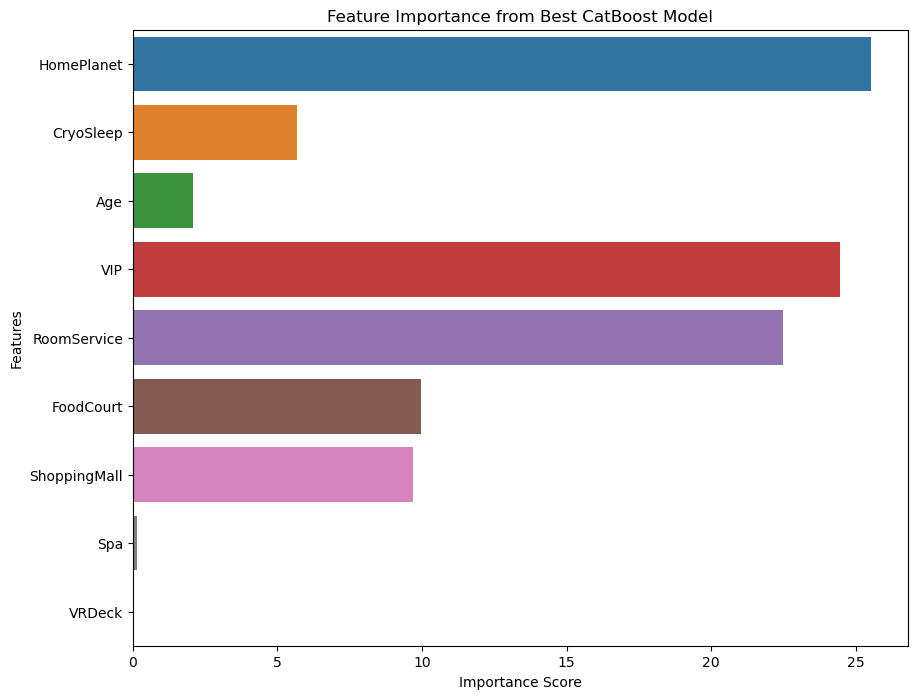

In [92]:
param_grid = {
    'model__iterations': [50, 100, 200,300,400],
    'model__learning_rate': [0.02, 0.06, 0.1],
    'model__depth': [4, 6, 8]
}

grid_search = GridSearchCV(cat_pipeline, param_grid, cv=5, scoring='accuracy')

grid_search.fit(x_train, y_train)

best_model = grid_search.best_estimator_.named_steps['model']

# Get feature importances from the best model
feature_importances = best_model.get_feature_importance()
features = x_train.columns  # assuming X_train is a DataFrame with named columns

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances, y=features[1:])
plt.title("Feature Importance from Best CatBoost Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

In [93]:
# cheking best model in test dataset

In [94]:
xgb_pipeline.fit(X, y)
predict_real = xgb_pipeline.predict(X)

print("Accuracy in the test dataset XGB:", accuracy_score(y, predict_real))
print("Report XGB:\n", classification_report(y, predict_real))

Accuracy in the test dataset XGB: 0.8121477050500403
Report XGB:
               precision    recall  f1-score   support

       False       0.85      0.76      0.80      4315
        True       0.78      0.87      0.82      4378

    accuracy                           0.81      8693
   macro avg       0.82      0.81      0.81      8693
weighted avg       0.82      0.81      0.81      8693



In [95]:
cat_pipeline.fit(X, y)
predict_real_cat = cat_pipeline.predict(X)

print("Accuracy in the test dataset CatBoost:", accuracy_score(y, predict_real_cat))
print("Report CatBoost:\n", classification_report(y, predict_real_cat))

Accuracy in the test dataset CatBoost: 0.7965029333946854
Report CatBoost:
               precision    recall  f1-score   support

       False       0.82      0.76      0.79      4315
        True       0.78      0.83      0.80      4378

    accuracy                           0.80      8693
   macro avg       0.80      0.80      0.80      8693
weighted avg       0.80      0.80      0.80      8693



In [107]:
# on trainig set Catboot is giving the good accuracy but on test data it's worse as comared to the xgboost,
# xgboost is giving slightly less accuuray as compared but working fine on test data 
# so considering xgboost

In [108]:
results = xgb_pipeline.predict(df_test)

submission = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],
    'Transported': results.astype(bool)
})

submission.to_csv('submission.csv',index=False)

In [109]:
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True
